# ANALYZE THE RESULTS AND MODELS FROM THE BEST APPROACH

In [9]:
from libraries import *
from my_functions import *

Here I am going to analyze the models built, select the best one and test it against the external dataset.  

In [10]:
dataframe=load_data()
dataframe.head()


[INFO] Loading data


,X,Y,area,perimeter,roi,image,category,Brep,Trep,group,chemistry,path_decon,path_raw,expected,1,2,3,4
0,462.658045,123.805411,200.299,53.891,2,1,OFQv67_w3,OFQv67,w3,36plex-1K eLIT,JEB,../20190204_OFQv67/detect_toto_w3/OFQv67_w3_1_...,merged/OFQv67/w3/1/roi_2.tif,66,10,58,61,54
1,366.437019,411.463645,191.621,52.759,5,1,OFQv67_w3,OFQv67,w3,36plex-1K eLIT,JEB,../20190204_OFQv67/detect_toto_w3/OFQv67_w3_1_...,merged/OFQv67/w3/1/roi_5.tif,66,13,55,60,54
2,196.810109,88.081063,131.091,43.654,2,2,OFQv67_w3,OFQv67,w3,36plex-1K eLIT,JEB,../20190204_OFQv67/detect_toto_w3/OFQv67_w3_2_...,merged/OFQv67/w3/2/roi_2.tif,66,18,59,59,58
3,398.738159,94.008875,175.333,51.952,3,2,OFQv67_w3,OFQv67,w3,36plex-1K eLIT,JEB,../20190204_OFQv67/detect_toto_w3/OFQv67_w3_2_...,merged/OFQv67/w3/2/roi_3.tif,66,16,60,59,56
4,150.306217,164.407736,117.149,40.415,4,2,OFQv67_w3,OFQv67,w3,36plex-1K eLIT,JEB,../20190204_OFQv67/detect_toto_w3/OFQv67_w3_2_...,merged/OFQv67/w3/2/roi_4.tif,66,18,64,61,52


In [11]:
def prepare_test(dataframe, images_df, test_index, channels, rounds, size, raw, group=""):
    for i, row in dataframe.iterrows():
        if i in test_index:
            a = tiff.imread("../../"+row['path_decon'])
            a = a.astype(np.float32)
            a,b=prepare_image1(a, channels, row, rounds, size, raw)
            images_df=add_image(images_df, b, row, group)
                
    return images_df


test_index=np.load("../../test_index.npy")

# SELECT THE BEST MODELS

Best model with 1 round:   fold 4 approach 15   
Best model with 2 rounds: fold 1 approach 9   
Best model with 3 rounds: fold 1 approach 9      
Best model with 4 rounds: fold 1 approach 9  

# MODEL 4
Model using only the first round of sequencing.  
Test against the external dataset  
Best model with 4 rounds:  fold 1 approach 9

9/9 [==============================] - 0s 43ms/step - loss: 0.0123
[METRICS] Loss:  0.012349355965852737
[METRICS] ROC AUC=0.924
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.6140615
[RESULT] Accuracy: 0.8206106870229007
[RESULT] TPR: 0.8190954773869347
[RESULT] TNR: 0.8253968253968254


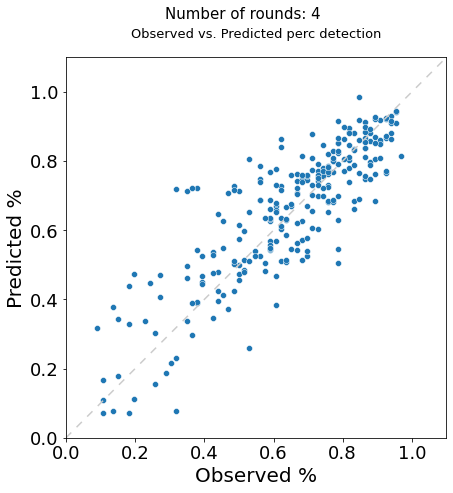

In [35]:
model4 = keras.models.load_model('../Model9_r4_fold1')
rounds_used=4
val_index=np.load("../../fold1.npy")
train_index=np.load("../../train_index.npy")
mask = np.isin(train_index, val_index)
train=train_index[~mask]
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])

#VALIDATION SET
images=prepare_test(dataframe, images, val_index, 4, rounds_used, 150, False)
threshold=0.5
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>0.5
p_lab=preds[:,0]>0.61
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



4/4 [==============================] - 0s 39ms/step - loss: 0.0149
[METRICS] Loss:  0.014891527593135834
[METRICS] ROC AUC=0.939
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.60242987
[RESULT] Accuracy: 0.88
[RESULT] TPR: 0.8793103448275862
[RESULT] TNR: 0.8888888888888888


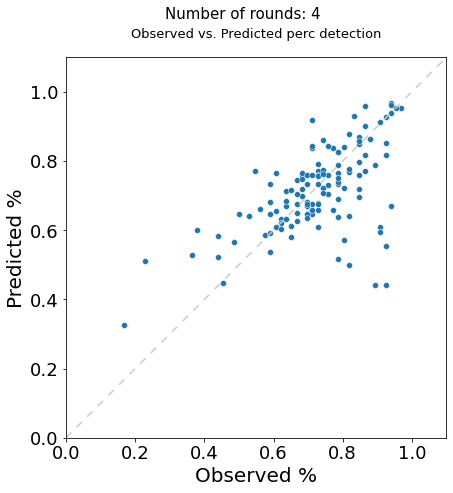

In [39]:
#EXTERNAL TEST
test_index=np.load("../../test_index.npy")
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])
images=prepare_test(dataframe, images, test_index, 4, rounds_used, 150, False)
threshold=0.5
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>0.5
p_lab=preds[:,0]>0.61
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



# MODEL 3

9/9 [==============================] - 0s 40ms/step - loss: 0.0096
[METRICS] Loss:  0.009626414626836777
[METRICS] ROC AUC=0.939
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.708299
[RESULT] Accuracy: 0.8587786259541985
[RESULT] TPR: 0.8547008547008547
[RESULT] TNR: 0.8928571428571429


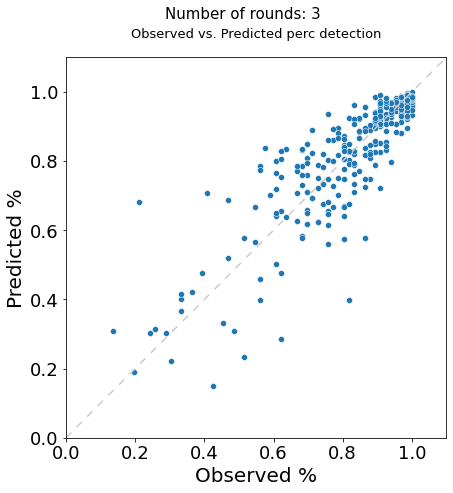

In [51]:
model4 = keras.models.load_model('../Model9_r3_fold1')
rounds_used=3
val_index=np.load("../../fold1.npy")
train_index=np.load("../../train_index.npy")
mask = np.isin(train_index, val_index)
train=train_index[~mask]
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])

#VALIDATION SET
images=prepare_test(dataframe, images, val_index, 4, rounds_used, 150, False)
threshold=0.6
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>threshold
opt_threshold=thresholds[np.argmin(abs(tpr-(1-fpr)))]
p_lab=preds[:,0]>opt_threshold
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



4/4 [==============================] - 0s 37ms/step - loss: 0.0131
[METRICS] Loss:  0.013062580488622189
[METRICS] ROC AUC=0.940
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.73966104
[RESULT] Accuracy: 0.88
[RESULT] TPR: 0.8869565217391304
[RESULT] TNR: 0.8


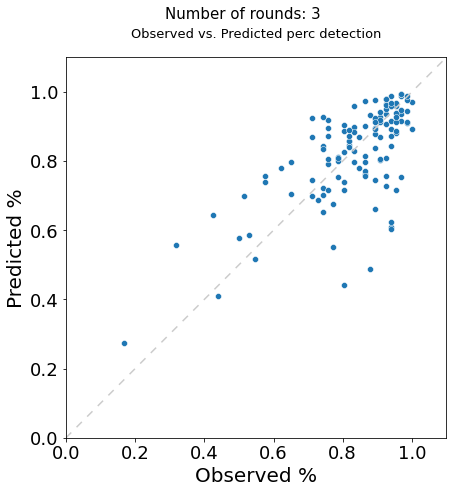

In [52]:
#EXTERNAL TEST
test_index=np.load("../../test_index.npy")
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])
images=prepare_test(dataframe, images, test_index, 4, rounds_used, 150, False)
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>threshold
p_lab=preds[:,0]>opt_threshold
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



# MODEL 2

9/9 [==============================] - 0s 39ms/step - loss: 0.0086
[METRICS] Loss:  0.008575589396059513
[METRICS] ROC AUC=0.882
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.76272756
[RESULT] Accuracy: 0.7977099236641222
[RESULT] TPR: 0.795
[RESULT] TNR: 0.8064516129032258


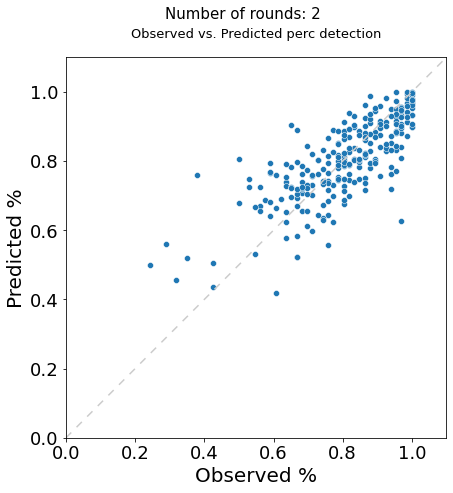

In [54]:
model4 = keras.models.load_model('../Model9_r2_fold1')
rounds_used=2
val_index=np.load("../../fold1.npy")
train_index=np.load("../../train_index.npy")
mask = np.isin(train_index, val_index)
train=train_index[~mask]
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])

#VALIDATION SET
images=prepare_test(dataframe, images, val_index, 4, rounds_used, 150, False)
threshold=0.7
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>threshold
opt_threshold=thresholds[np.argmin(abs(tpr-(1-fpr)))]
p_lab=preds[:,0]>opt_threshold
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



4/4 [==============================] - 0s 35ms/step - loss: 0.0109
[METRICS] Loss:  0.010930775664746761
[METRICS] ROC AUC=0.869
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.7558006
[RESULT] Accuracy: 0.8
[RESULT] TPR: 0.7857142857142857
[RESULT] TNR: 0.8518518518518519


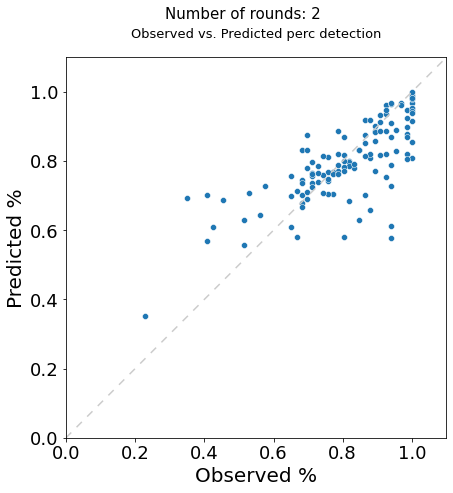

In [55]:
#EXTERNAL TEST
test_index=np.load("../../test_index.npy")
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])
images=prepare_test(dataframe, images, test_index, 4, rounds_used, 150, False)
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>threshold
p_lab=preds[:,0]>opt_threshold
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



# MODEL 1

9/9 [==============================] - 5s 541ms/step - loss: 0.0091
[METRICS] Loss:  0.00907785166054964
[METRICS] ROC AUC=0.824
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.2092753
[RESULT] Accuracy: 0.7662835249042146
[RESULT] TPR: 0.7596153846153846
[RESULT] TNR: 0.7707006369426752


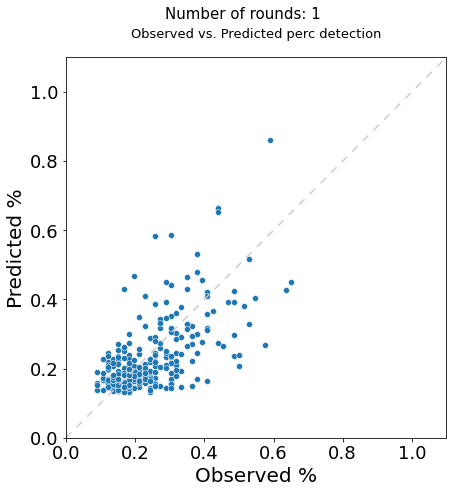

In [57]:
model4 = keras.models.load_model('../../approach15/Model9_r1_fold4')
rounds_used=1
val_index=np.load("../../fold4.npy")
train_index=np.load("../../train_index.npy")
mask = np.isin(train_index, val_index)
train=train_index[~mask]
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])

#VALIDATION SET
images=prepare_test(dataframe, images, val_index, 4, rounds_used, 150, False)
threshold=0.25
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>threshold
opt_threshold=thresholds[np.argmin(abs(tpr-(1-fpr)))]
p_lab=preds[:,0]>opt_threshold
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)



4/4 [==============================] - 3s 798ms/step - loss: 0.0169
[METRICS] Loss:  0.016856784000992775
[METRICS] ROC AUC=0.712
[INFO] plotting results ... 
[RESULT] Optimal threshold: 0.20996821
[RESULT] Accuracy: 0.64
[RESULT] TPR: 0.6385542168674698
[RESULT] TNR: 0.6428571428571429


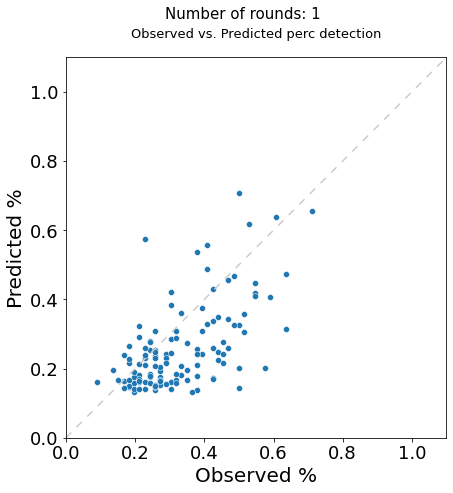

In [59]:
#EXTERNAL TEST
test_index=np.load("../../test_index.npy")
images = pd.DataFrame(columns=["image_array", "image", "roi", "category", "area", "perimeter", "chemistry", "X", "Y", "file", 'expected', 'observed_r1', 'observed_r2', 'observed_r3', 'observed_r4', "group"])
images=prepare_test(dataframe, images, test_index, 4, rounds_used, 150, False)
x_test, y_test=prepare_dataset_1(images, rounds_used)
auc, fpr, tpr, thresholds, loss, preds=evaluate_model(x_test, y_test, model4, threshold)
name_model="_r4_fold3"
approach=""
create_plots2(approach, fpr, tpr, thresholds, y_test, preds, rounds_used, "ROC_curve"+name_model+"TEST", "result_model"+name_model+"TEST")
print(colored("\n[RESULT]", "green"), "Optimal threshold:", str(thresholds[np.argmin(abs(tpr-(1-fpr)))]))
y_lab=y_test>threshold
p_lab=preds[:,0]>opt_threshold
print(colored("[RESULT]", "green"), "Accuracy:", sum(y_lab==p_lab)/len(y_lab))

total_true=0
true_pos=0
for i in range(len(y_lab)):
    if y_lab[i]==True:
        total_true+=1
        if p_lab[i]==True:
            true_pos+=1
TPR=true_pos/total_true
print(colored("[RESULT]", "green"), "TPR:", TPR)

total_neg=0
true_neg=0
for i in range(len(y_lab)):
    if y_lab[i]==False:
        total_neg+=1
        if p_lab[i]==False:
            true_neg+=1
TNR=true_neg/total_neg
print(colored("[RESULT]", "green"), "TNR:", TNR)

